In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv(r'C:\Users\One\Git\COURSERA YANDEX\Course 4\week 17\credit_scoring\credit_card_default_analysis.csv')

In [4]:
data.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


 ### 1. Гипотеза о равенстве медианных значений кредитного лимита

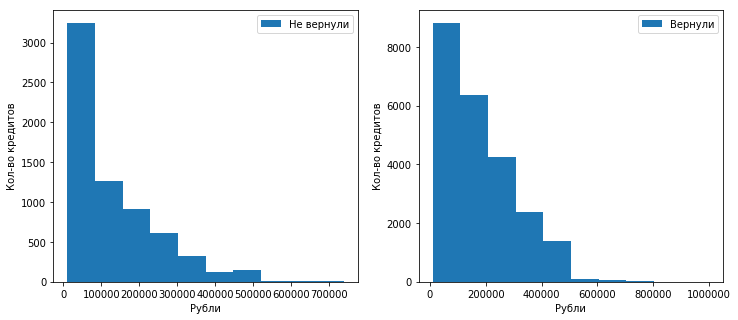

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.hist((data['LIMIT_BAL'][data['default'] == 1]), label = 'Не вернули')
plt.legend()
plt.xlabel('Рубли')
plt.ylabel('Кол-во кредитов')

plt.subplot(1,2,2)
plt.hist((data['LIMIT_BAL'][data['default'] == 0]), label = 'Вернули')
plt.xlabel('Рубли')
plt.ylabel('Кол-во кредитов')
plt.legend()
plt.show()

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [7]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

#### Функции для использования перестановочного критерия для двух несвязанных выборок

In [8]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [36]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [37]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [39]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

#### Проверяю гипотезу о равенстве средних в зависимости от кредитного лимита:

In [40]:
from scipy.stats import ttest_ind
ttest_ind(data['LIMIT_BAL'][data['default'] == 0], data['LIMIT_BAL'][data['default'] == 1])

Ttest_indResult(statistic=26.908521684796522, pvalue=1.3022439532597397e-157)

#### Проверяю гипотезу о равенстве медиан в зависимости от кредитного лимита:

In [41]:
bootstrapped_0 = get_bootstrap_samples(data['LIMIT_BAL'][data['default'] == 0].values, 1000)
bootstrapped_1 = get_bootstrap_samples(data['LIMIT_BAL'][data['default'] == 1].values, 1000)

In [42]:
medians_delta = np.median(bootstrapped_0, axis=1) - np.median(bootstrapped_1, axis=1)

In [43]:
stat_intervals(medians_delta, 0.05)

array([60000., 70000.])

#### Так как доверительный интервал больше нуля, то между медианами групп есть значимая разница.
#### Далее проверяю гипотезу о равенстве распределений.

In [45]:
np.random.seed(0)
permutation_test(data['LIMIT_BAL'][data['default'] == 0].values, 
                 data['LIMIT_BAL'][data['default'] == 1].values, max_permutations = 10000, alternative='greater')

0.0001

In [47]:
%%time
np.random.seed(0)
print(permutation_test(data['LIMIT_BAL'][data['default'] == 0].values, 
                 data['LIMIT_BAL'][data['default'] == 1].values, max_permutations = 10000, alternative='two-sided'))

0.0001
Wall time: 1min 10s


#### Уровень значимости меньше 0.05, отвергаем гипотезу о равенстве выборок.
### 2. Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. 

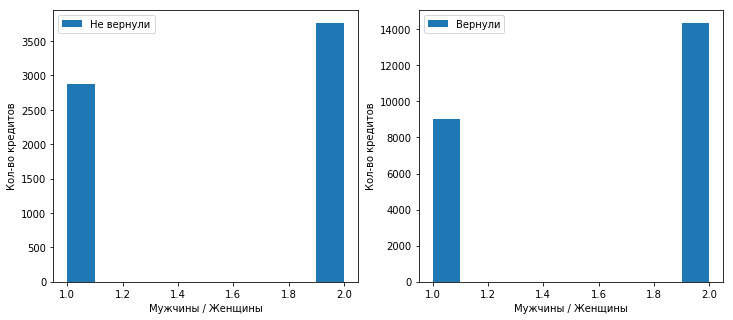

In [68]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.hist((data['SEX'][data['default'] == 1]), label = 'Не вернули')
plt.legend()
plt.xlabel('Мужчины / Женщины')
plt.ylabel('Кол-во кредитов')

plt.subplot(1,2,2)
plt.hist((data['SEX'][data['default'] == 0]), label = 'Вернули')
plt.xlabel('Мужчины / Женщины')
plt.ylabel('Кол-во кредитов')
plt.legend()
plt.show()

#### Разница в соотношении добропорядочных заемщиков видна визуально.

In [52]:
import scipy
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [49]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [50]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [62]:
from statsmodels.stats.proportion import proportion_confint
proportion_confint(sum(data['SEX'][data['default'] == 0]-1), len(data['SEX'][data['default'] == 0]-1))

(0.6079080143666044, 0.6203919342723273)

In [61]:
proportion_confint(sum(data['SEX'][data['default'] == 1]-1), len(data['SEX'][data['default'] == 1]-1))

(0.5551371736238107, 0.5789797642905956)

#### Выше приведены доверетельные интервалы для долей женщин вернувших и не вернувших кредит. Итервалы не пересекаются - значит гендерный состав групп разный.

In [56]:
proportions_diff_confint_ind(data['SEX'][data['default'] == 0] - 1, data['SEX'][data['default'] == 1] - 1)

(0.03363493274962867, 0.060548077974896725)

In [63]:
proportions_diff_z_test(proportions_diff_z_stat_ind(data['SEX'][data['default'] == 0] - 1, data['SEX'][data['default'] == 1] - 1))

4.472866521609831e-12

#### Доверительный интервал разницы долей не включает нулевое значение, а достигаемый уровень значимости меньше 0.05 - значит отвергается нулевая гипотеза о равенстве выборок.

### 3. Гипотеза  о том, что образование не влияет на то, вернет ли человек долг.

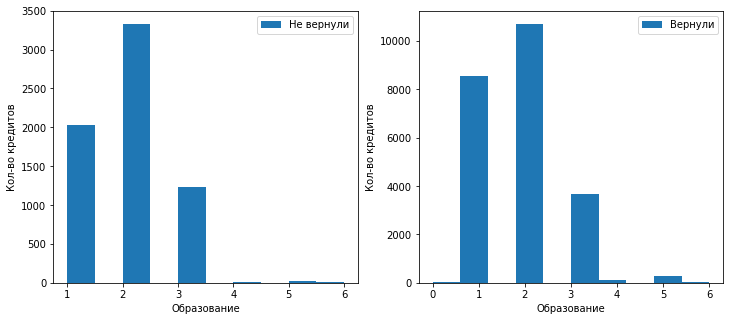

In [69]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.hist((data['EDUCATION'][data['default'] == 1]), label = 'Не вернули')
plt.legend()
plt.xlabel('Образование')
plt.ylabel('Кол-во кредитов')

plt.subplot(1,2,2)
plt.hist((data['EDUCATION'][data['default'] == 0]), label = 'Вернули')
plt.xlabel('Образование')
plt.ylabel('Кол-во кредитов')
plt.legend()
plt.show()

#### Визуально заметно, что процент невозврата долга в группах образованности разный.

In [70]:
data['EDUCATION'][data['default'] == 1].describe()

count    6636.000000
mean        1.894665
std         0.728096
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: EDUCATION, dtype: float64

In [84]:
data[data['default'] == 1].groupby('EDUCATION')['default'].count()

EDUCATION
1    2036
2    3330
3    1237
4       7
5      18
6       8
Name: default, dtype: int64

In [82]:
data[data['default'] == 0].groupby('EDUCATION')['default'].count()

EDUCATION
0       14
1     8549
2    10700
3     3680
4      116
5      262
6       43
Name: default, dtype: int64

#### Доля отдавших долг среди людей с докторской, магистерской степенями, начальным и прочим образованием выше ожидаемой. Доля отдавших долг среди людей со степенью бакалавра и выпускниками школ ниже ожидаемой.

### 4. Связь семейного статуса с индикатором дефолта

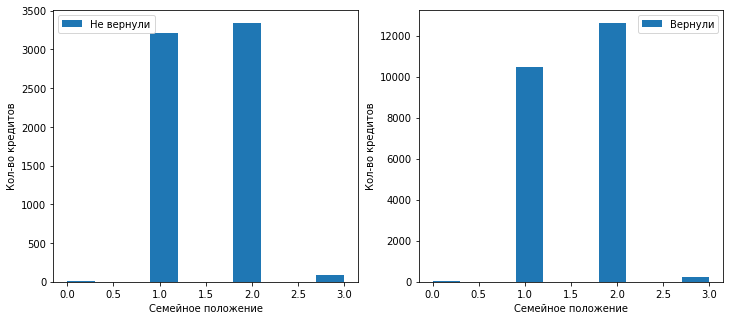

In [89]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.hist((data['MARRIAGE'][data['default'] == 1]), label = 'Не вернули')
plt.legend()
plt.xlabel('Семейное положение')
plt.ylabel('Кол-во кредитов')

plt.subplot(1,2,2)
plt.hist((data['MARRIAGE'][data['default'] == 0]), label = 'Вернули')
plt.xlabel('Семейное положение')
plt.ylabel('Кол-во кредитов')
plt.legend()
plt.show()

#### Если не принимать во внимание 0 и 3 категорию, то заметна разница в соотношении холостяков (кат. 2) в группах людей, вернувших и не вернувших кредит. Проверим гипотезу об одинаковой доле холостяков в группах людей вернувших и не вернувших кредит с помощью Z-критерия для разности долей.

In [93]:
proportions_diff_z_test(proportions_diff_z_stat_ind(data['MARRIAGE'][data['default'] == 0] - 1, 
                                                    data['MARRIAGE'][data['default'] == 1] - 1))

9.657346852876003e-06

#### Достигаемый уровень значимости позволяет сделать вывод, что доля холостяков в группах людей вернувших и не вернувших кредит различна.

### 5. Гипотезы о возрасте

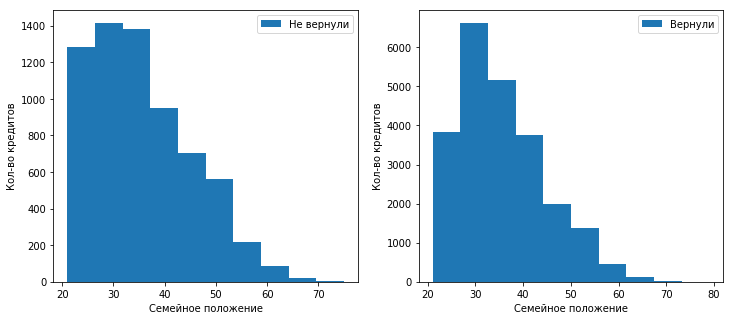

In [97]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.hist((data['AGE'][data['default'] == 1]), label = 'Не вернули')
plt.legend()
plt.xlabel('Семейное положение')
plt.ylabel('Кол-во кредитов')

plt.subplot(1,2,2)
plt.hist((data['AGE'][data['default'] == 0]), label = 'Вернули')
plt.xlabel('Семейное положение')
plt.ylabel('Кол-во кредитов')
plt.legend()
plt.show()

#### Визуально разницы не заметно. Проверим с помощью доверительных интервалов.

In [98]:
bootstrapped_0 = get_bootstrap_samples(data['AGE'][data['default'] == 0].values, 1000)
bootstrapped_1 = get_bootstrap_samples(data['AGE'][data['default'] == 1].values, 1000)

medians_delta = np.median(bootstrapped_0, axis=1) - np.median(bootstrapped_1, axis=1)

stat_intervals(medians_delta, 0.05)

array([-1.,  0.])

#### Доверительный интервал включает 0 - утверждать о равенстве медианных значений возрастов нельзя.

In [99]:
np.random.seed(0)
permutation_test(data['AGE'][data['default'] == 0].values, 
                 data['AGE'][data['default'] == 1].values, max_permutations = 10000, alternative='greater')

0.991

In [108]:
12*1+9*2+8*5+8*10+1*50

200

#### Достигаемый уровень значимости меньше 0.05 - значит гипотеза о равенстве распределения возрастов людей отвергается.